In [10]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.1"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
from corrector_src.data.load_sim import (
    load_states,
    integrate_blast,
    filepath_state,
    prepare_initial_state,
)
from corrector_src.utils.downaverage import downaverage_states, downaverage_state

from corrector_src.data.dataset import dataset

In [2]:
with initialize(version_base=None, config_path="../../configs"):
    cfg = compose(config_name="config")
    print(cfg)


{'experiment': {'name': 'experiment_1'}, 'data': {'debug': '${training.debug}', 'hr_res': 64, 'downscaling_factor': 2, 'randomizer_1': [0.5, 1.5], 'randomizer_2': [0.5, 1.5], 'randomizer_3': [0.5, 1.5], 'num_snapshots': 80, 'num_checkpoints': 10, 'num_timesteps': 1000, 'generate_data_on_fly': False, 'precomputed_data': True, 'fixed_timestep': False, 'dt_max': 0.1, 't_end': 0.34, 'snapshot_timepoints': [0.2, 0.34], 'use_specific_snapshot_timepoints': True, 'return_snapshots': True}, 'training': {'epochs': 300, 'n_look_behind': 10, 'learning_rate': 0.001, 'return_full_sim': False, 'return_full_sim_epoch_interval': 10, 'rng_key': 60, 'debug': False}, 'models': {'_target_': 'corrector_src.model._cnn_mhd_corrector.CorrectorCNN', 'in_channels': 8, 'hidden_channels': 16}}


In [3]:
dataset = dataset([1], cfg.data)

In [ ]:
resolution=128
sim_assets_hr, sim_assets_lr = dataset.train_initializator(64, 2)


In [5]:
import matplotlib.pyplot as plt

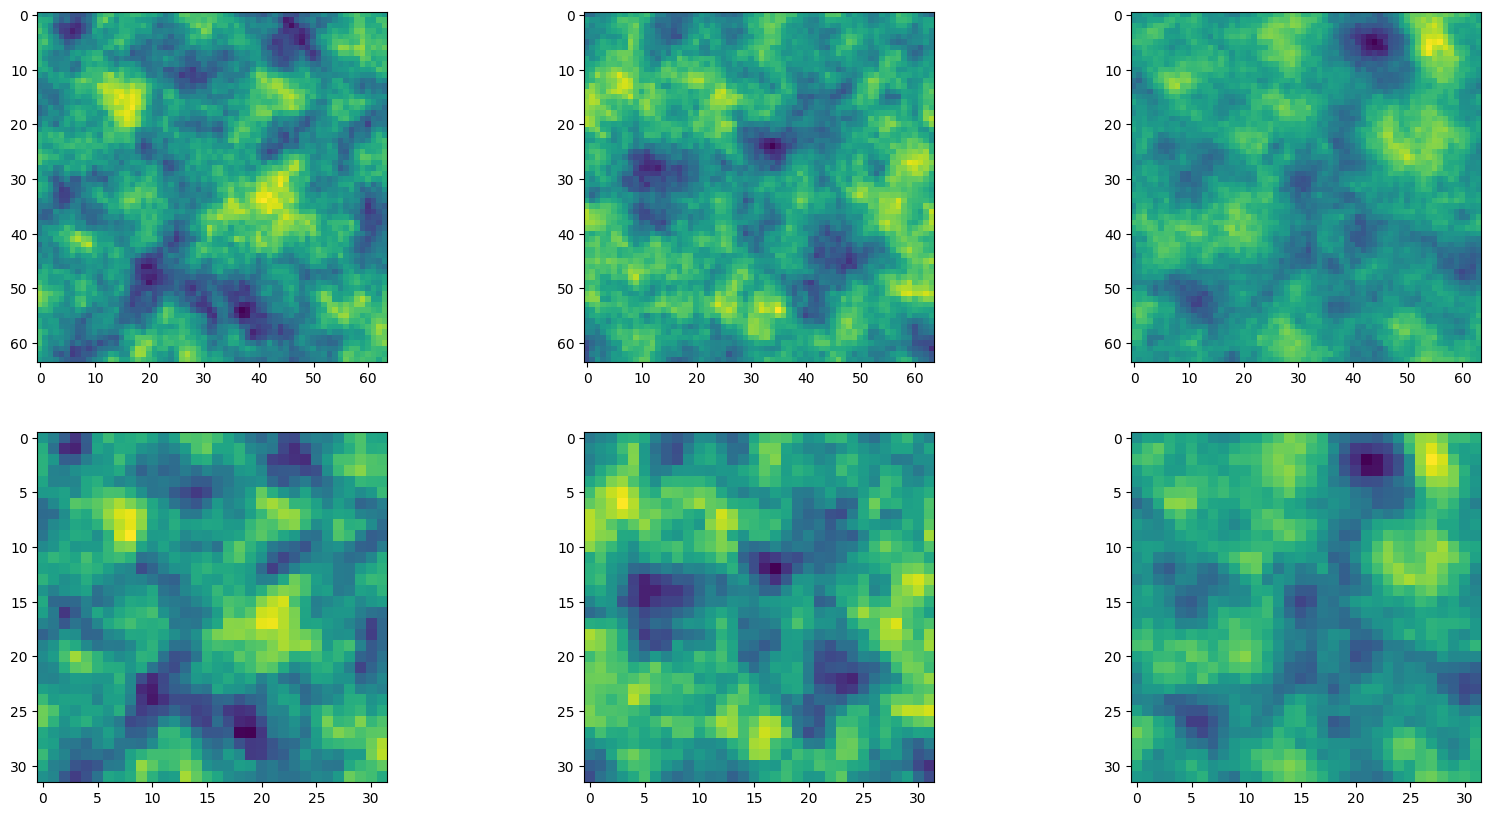

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
states = [sim_assets_hr[0], sim_assets_lr[0]]
z_level = [0, 0]
for i in range(2):
    ax[i][0].imshow(states[i][1, : ,:, z_level[i]])
    ax[i][1].imshow(states[i][2, :, :, z_level[i]])
    ax[i][2].imshow(states[i][3, :, :, z_level[i]])

In [ ]:
from jf1uids import time_integration
hr_snapshot_data = time_integration(*sim_assets_hr)

hr_downscaled_snapshot_data = time_integration(*sim_assets_lr)


In [8]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import jax.numpy as jnp


def plot_and_animate_states(states_list, z_levels, titles=None, vmin=0, vmax=1):
    """
    Plot and animate multiple simulation states (e.g. LR, HR, etc.)

    Args:
        states_list: list of 5D arrays [batch, channel, x, y, z]
        z_levels: list of z-level indices corresponding to each state array
        titles: optional list of titles (e.g. ["LR", "HR"])
        vmin, vmax: normalization range for color scaling
    """

    n_states = len(states_list)
    n_fields = 3 # density, velocity magnitude, pressure, magnetic field

    if titles is None:
        titles = [f"State {i + 1}" for i in range(n_states)]

    fig, axs = plt.subplots(n_states, n_fields, figsize=(5 * n_fields, 5 * n_states))
    if n_states == 1:
        axs = axs[None, :]  # handle single row case

    # Store all imshow handles for animation
    caxs = []

    for row, (states, z_level, title_prefix) in enumerate(
        zip(states_list, z_levels, titles)
    ):
        # --- Field 1: Density ---
        c0 = axs[row][0].imshow(
            states[0, 0, :, :, z_level].T,
            origin="lower",
            norm=plt.Normalize(vmin=vmin, vmax=vmax),
        )
        fig.colorbar(c0, ax=axs[row][0])
        axs[row][0].set_title(f"{title_prefix} - Density")
        axs[row][0].set_xlabel("x")
        axs[row][0].set_ylabel("y")

        # --- Field 2: Velocity magnitude ---
        c1 = axs[row][1].imshow(
            jnp.sqrt(
                states[0, 1, :, :, z_level] ** 2
                + states[0, 2, :, :, z_level] ** 2
                + states[0, 3, :, :, z_level] ** 2
            ).T,
            origin="lower",
            norm=plt.Normalize(vmin=vmin, vmax=vmax),
        )
        fig.colorbar(c1, ax=axs[row][1])
        axs[row][1].set_title(f"{title_prefix} - Velocity Magnitude")

        # --- Field 3: Pressure ---
        c2 = axs[row][2].imshow(
            states[0, 4, :, :, z_level].T,
            origin="lower",
            norm=plt.Normalize(vmin=vmin, vmax=vmax),
        )
        fig.colorbar(c2, ax=axs[row][2])
        axs[row][2].set_title(f"{title_prefix} - Pressure")


        # Store for animation
        caxs.append((c0, c1, c2))

    plt.tight_layout()

    # --- Animation function ---
    def animate_all(i):
        updated = []
        for (states, z_level), (c0, c1, c2) in zip(
            zip(states_list, z_levels), caxs
        ):
            c0.set_array(states[i, 0, :, :, z_level].T)
            c1.set_array(
                jnp.sqrt(
                    states[i, 1, :, :, z_level] ** 2
                    + states[i, 2, :, :, z_level] ** 2
                    + states[i, 3, :, :, z_level] ** 2
                ).T
            )
            c2.set_array(states[i, 4, :, :, z_level].T)
            
            updated.extend([c0, c1, c2])
        return updated

    # Use frame count from first state
    n_frames = states_list[0].shape[0]
    ani = animation.FuncAnimation(fig, animate_all, frames=n_frames, interval=50)

    html_video = HTML(ani.to_html5_video())
    return html_video


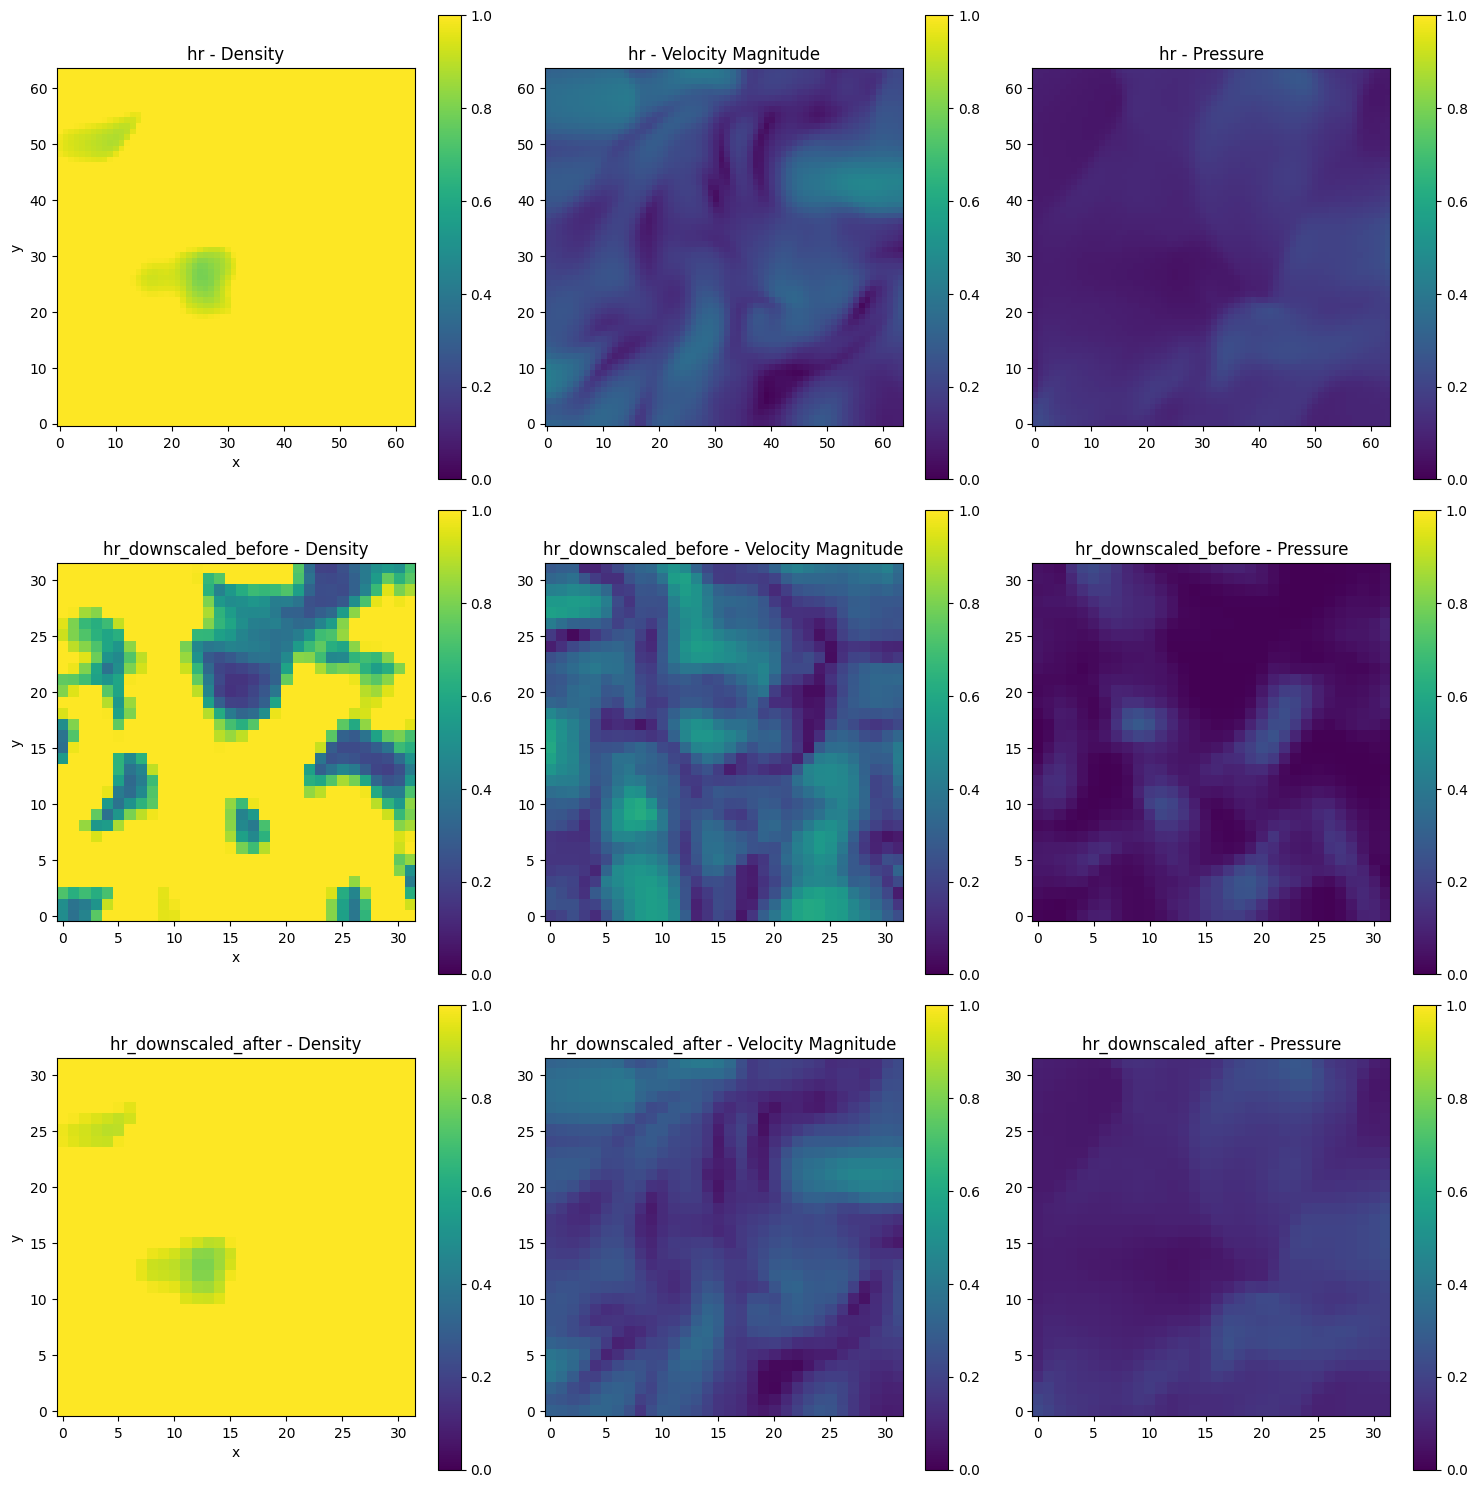

In [12]:
downscaled_after_hr_states = downaverage_states(hr_snapshot_data.states, 2)
plot_and_animate_states([hr_snapshot_data.states, hr_downscaled_snapshot_data.states, downscaled_after_hr_states], [0,0,0], ["hr", "hr_downscaled_before", "hr_downscaled_after"])